# Informer Demo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive

<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'>

## Download code and dataset

In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159
Receiving objects: 100% (187/187), 3.86 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (62/62), done.
ETDataset  Informer2020  sample_data


In [ ]:
import sys
# print(sys.path)
# sys.path += ['/content/drive/MyDrive/informer']
# sys.path += ['/content/drive/MyDrive/informer/Informer2020']
# sys.path += ['/content/drive/MyDrive/informer/ETDataset']
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']


In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [1]:
try:
  from utils.tools import dotdict
  from exp.exp_informer import Exp_Informer
  import torch
except:
  from drive.informer.Informer2020.utils.tools import dotdict
  from drive.informer.Informer2020.exp.exp_informer import Exp_Informer
  import torch

In [2]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'heartbeat' # data
args.root_path = './FEDformer-master/ETDataset/ETT-small/' # root path of data file
args.data_path = 'newRR.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'data' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './checkpoints/' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 25 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [3]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [4]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'heartbeat':{'data':'newRR.csv','T':'data','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [5]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [6]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'heartbeat', 'root_path': './FEDformer-master/ETDataset/ETT-small/', 'data_path': 'newRR.csv', 'features': 'S', 'target': 'data', 'freq': 'h', 'checkpoints': './checkpoints/', 'seq_len': 96, 'label_len': 48, 'pred_len': 25, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [7]:
Exp = Exp_Informer

In [8]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    break
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0


## Prediction

In [9]:
import os

# set saved model path
# setting = 'informer_heartbeat_ftS_sl96_ll48_pl3000_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [10]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)
#
preds,trues = exp.predict(setting, True)

Use GPU: cuda:0
testRR.csv
pred 1881


In [13]:

print(preds)

[-0.12013903, -0.11949359, -0.12453748, -0.1188346, -0.0134264715, -0.10152814, -0.035168078, -0.0678446, -0.18434936, -0.19187489, -0.19431925, -0.13320349, -0.21473464, -0.17292061, -0.22789668, -0.20460771, -0.40324423, -0.317736, -0.40153465, -0.37877014, -0.3427311, -0.37043396, -0.3744672, -0.37337804, -0.36493215, -0.33343068, -0.25605133, -0.22055522, -0.23236421, -0.26084855, -0.24054334, -0.21334782, -0.34981328, -0.35360977, -0.32491755, -0.19122872, -0.24679959, -0.28761217, -0.21091647, -0.25195393, -0.23494881, -0.292796, -0.28921053, -0.22440524, -0.07944254, -0.13113561, -0.11553419, -0.14782389, -0.16961156, -0.17417213, -0.61973256, -0.62353426, -0.6263396, -0.5603274, -0.5708052, -0.5680759, -0.56068, -0.54194456, -0.6297683, -0.65298474, -0.7188061, -0.7620012, -0.7479027, -0.61987793, -0.78968495, -0.6680425, -0.663503, -0.43687692, -0.32113656, 0.18829596, -0.3007083, 0.25336015, 0.6025961, 0.6189028, 0.63206536, 3.5217857, 3.6737032, 4.130184, 3.6707947, 3.257521

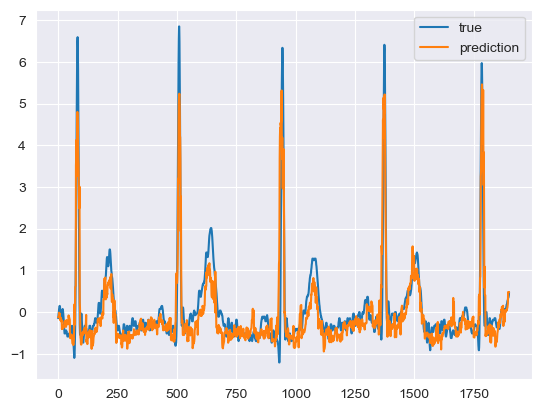

[-0.33318793773651123, -0.25878795981407166, -0.2151690572500229, -0.20432594418525696, -0.05432571843266487, -0.2362438142299652, -0.1587045043706894, -0.011572662740945816, 0.04546808823943138, 0.04311027750372887, 0.034673210233449936, 0.006994571536779404, 0.016606967896223068, 0.04668564721941948, 0.06146081164479256, 0.04845435544848442, 0.09684136509895325, 0.10381262004375458, 0.16330820322036743, 0.20239922404289246, 0.47991493344306946, 0.46963587403297424, 0.47430744767189026, 0.4728347361087799, 0.47996482253074646]


In [15]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# setting = 'informer_heartbeat_ftS_sl96_ll48_pl3000_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0'
# full_data = pd.read_csv('./ETDataset/ETT-small/newRR.csv')
# test_data = pd.read_csv('./ETDataset/ETT-small/testRR.csv')
# joint_data = pd.concat([full_data,test_data]).set_index("date")
prediction = np.load('./results/'+setting+'/real_prediction.npy')[0,:,-1].tolist()
true = np.load('./results/'+setting+'/true.npy')[0,:,-1].tolist()


# test_data = test_data.set_index('date')
# test_data["predict"] = prediction
plt.figure()
# plt.plot(joint_data['data'],label ="real")
# plt.plot(test_data["predict"],label="prediction")
plt.plot(trues,label="true")
plt.plot(preds,label="prediction")
plt.legend()
plt.show()
print(prediction)
# plt.figure()
# plt.plot(prediction[0,:,-1])
# plt.show()

### More details about Prediction - prediction function

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [ ]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
len(data_set), len(data_loader)

## Visualization

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((12736, 24, 1), (12736, 24, 1))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

[58.156326 58.154087 58.15047  58.14495  58.14348  58.143387 58.143387
 58.143284 58.14787  58.148846 58.146706 58.143806 58.143257 58.145947
 58.145527 58.149094 58.15686  58.15151  58.155403 58.178944 58.203506
 58.224808 58.2562   58.27519 ]


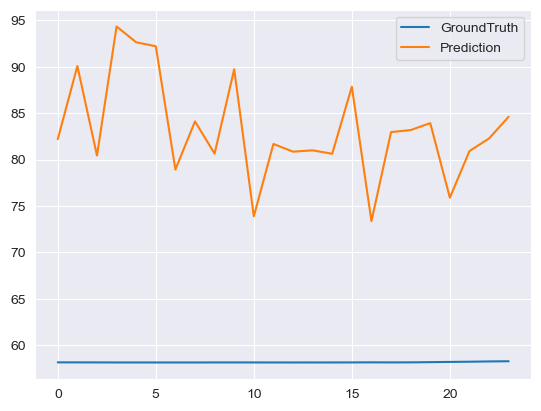

In [ ]:
# draw OT prediction
plt.figure()
print(trues[0,:,-1])
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

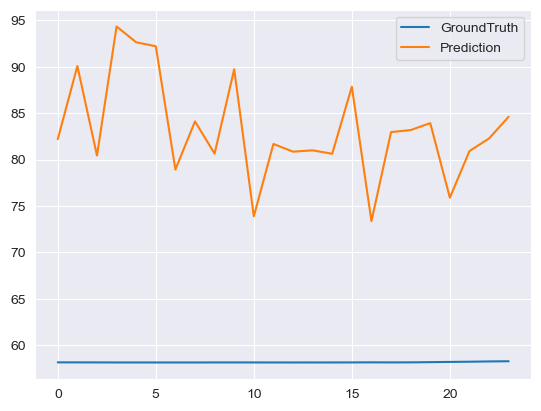

In [ ]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [ ]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

In [ ]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [ ]:
attn[0].shape, attn[1].shape #, attn[2].shape

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
df.head()

In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]